In [81]:
!pip list | grep "torch\|tensorflow\|transformers\|opencv\|scikit-learn"

opencv-contrib-python              4.10.0.84
opencv-python                      4.10.0.84
opencv-python-headless             4.10.0.84
pytorch-ignite                     0.5.1
pytorch-lightning                  2.5.0.post0
scikit-learn                       1.2.2
scikit-learn-intelex               2025.2.0
sentence-transformers              3.3.1
tensorflow                         2.17.1
tensorflow-cloud                   0.1.5
tensorflow-datasets                4.9.7
tensorflow_decision_forests        1.10.0
tensorflow-hub                     0.16.1
tensorflow-io                      0.37.1
tensorflow-io-gcs-filesystem       0.37.1
tensorflow-metadata                1.13.1
tensorflow-probability             0.24.0
tensorflow-text                    2.17.0
torch                              2.5.1+cu121
torchaudio                         2.5.1+cu121
torchinfo                          1.8.0
torchmetrics                       1.6.1
torchsummary                       1.5.1
torchtune       

In [82]:
!rm -rf /kaggle/working/results/checkpoint-*
!rm -rf /kaggle/working/logs/*


In [83]:
!pip install torch torchvision transformers opencv-python scikit-learn

In [84]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import ViTForImageClassification
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

In [85]:
# Define the transformations for the images
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [86]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
from torchvision import transforms
from PIL import Image
import os

# Load the CSV file
csv_path = '/kaggle/input/mddb-text-updated/Thesis_Updated.csv'
df = pd.read_csv(csv_path)

# Verify column names
print(df.columns)

# Drop unnecessary columns if they exist
columns_to_drop = [col for col in ['label','Source', 'Domain', 'Unnamed: 5'] if col in df.columns]
df = df.drop(columns_to_drop, axis=1)

# Shuffle the dataframe
df = shuffle(df, random_state=42)

# Split the dataset
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

train_data, val_test = train_test_split(df, train_size=train_ratio, random_state=42)
valid_data, test_data = train_test_split(val_test, train_size=val_ratio / (val_ratio + test_ratio), random_state=42)

Index([' id', 'caption', 'label', 'level', 'area', 'Unnamed: 5'], dtype='object')


In [87]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
from torchvision import transforms

class ImageDataset(Dataset):
    def __init__(self, dataframe, images_folder, image_transforms):
        self.dataframe = dataframe
        self.images_folder = images_folder
        self.image_transforms = image_transforms

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        label = row['level']
        image_id = row[' id']

        image_path_jpg = os.path.join(self.images_folder, f"{image_id}.jpg")
        image_path_png = os.path.join(self.images_folder, f"{image_id}.png")
        image_path_jpeg = os.path.join(self.images_folder, f"{image_id}.jpeg")

        if os.path.exists(image_path_jpg):
            image_path = image_path_jpg
        elif os.path.exists(image_path_png):
            image_path = image_path_png
        elif os.path.exists(image_path_jpeg):
            image_path = image_path_jpeg
        else:
            raise FileNotFoundError(f"Image {image_id} not found with .jpg or .png extension")

        image = Image.open(image_path).convert('RGB')
        image = self.image_transforms(image)

        label = int(label)
        assert 0 <= label < 2, f"Label {label} out of range"

        return {
            'original_label': label,
            'pixel_values': image,
            'label': torch.tensor(label, dtype=torch.long)
        }

In [88]:
# Path to the images folder
images_folder = '/kaggle/input/multimodal-disaster-dataset-bangla/Multimodal Disaster Bangla Dataset/Photos_Final'

# Initialize datasets
train_dataset = ImageDataset(train_data, images_folder, image_transforms)
valid_dataset = ImageDataset(valid_data, images_folder, image_transforms)
test_dataset = ImageDataset(test_data, images_folder, image_transforms)

In [89]:
# Initialize data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Sample 1:
Original Label: Informative


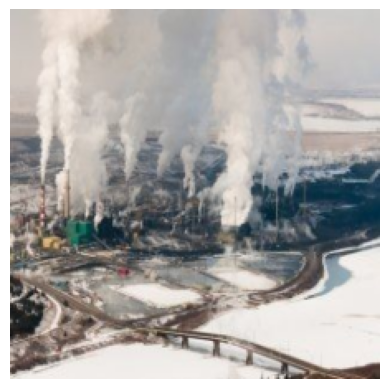


Sample 2:
Original Label: Informative


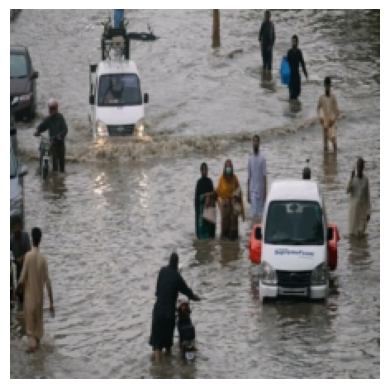


Sample 3:
Original Label: Non Informative


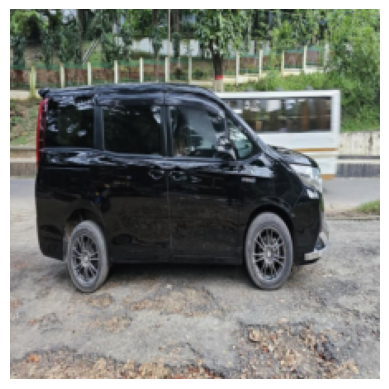


Sample 4:
Original Label: Informative


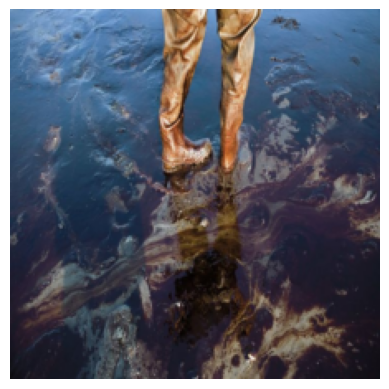


Sample 5:
Original Label: Non Informative


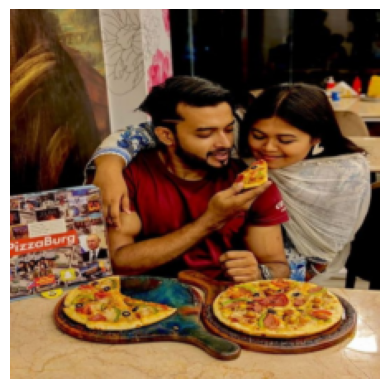

In [90]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
from torchvision import transforms
import matplotlib.pyplot as plt

class ImageDataset(Dataset):
    def __init__(self, dataframe, images_folder, image_transforms):
        self.dataframe = dataframe
        self.images_folder = images_folder
        self.image_transforms = image_transforms

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        label = row['level']
        image_id = row[' id']

        image_path_jpg = os.path.join(self.images_folder, f"{image_id}.jpg")
        image_path_png = os.path.join(self.images_folder, f"{image_id}.png")
        image_path_jpeg = os.path.join(self.images_folder, f"{image_id}.jpeg")

        if os.path.exists(image_path_jpg):
            image_path = image_path_jpg
        elif os.path.exists(image_path_png):
            image_path = image_path_png
        elif os.path.exists(image_path_jpeg):
            image_path = image_path_jpeg
        else:
            raise FileNotFoundError(f"Image {image_id} not found with .jpg or .png extension")

        image = Image.open(image_path).convert('RGB')
        image = self.image_transforms(image)
        label = int(label)
        assert 0 <= label < 2, f"Label {label} out of range"

        return {
            'original_label': label,
            'pixel_values': image,
            'label': torch.tensor(label, dtype=torch.long)
        }

def imshow(image, ax=None, title=None, normalize=False):
    # Imshow for Tensor.
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))
    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
    ax.imshow(image)
    if title is not None:
        ax.set_title(title)
    ax.axis('off')
    return ax

def print_samples(dataloader, num_samples=5):
    count = 0
    for batch in dataloader:
        if count >= num_samples:
            break
        for i in range(len(batch['pixel_values'])):
            if count >= num_samples:
                break
            print(f"Sample {count+1}:")
            if batch['original_label'][i] == 1:
                print("Original Label: Informative")
            else:
                print("Original Label: Non Informative")
            
            # Plot the image
            imshow(batch['pixel_values'][i])
            plt.show()
            print()
            count += 1

# Example DataFrame
data = {
    'Caption': ['বাংলা টেক্সট ১', 'বাংলা টেক্সট ২'],
    'Label': [0, 1],
    'image id': ['image1', 'image2']
}
dataframe = df

# Path to the images folder
images_folder = '/kaggle/input/multimodal-disaster-dataset-bangla/Multimodal Disaster Bangla Dataset/Photos_Final'

# Initialize image transforms
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Initialize dataset
dataset = ImageDataset(dataframe, images_folder, image_transforms)
# Create DataLoader
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

# Print some samples from the dataset
print_samples(dataloader)

In [91]:
import torch
import torchvision.models as models
import torch.nn as nn
model = models.resnet50(pretrained=True)

# Freeze layers if you want to use it as a feature extractor only (optional)
# for param in model.parameters():
#     param.requires_grad = False

# Replace the final fully connected layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2) 

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [92]:
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

In [93]:
if torch.cuda.is_available():
    model.cuda()


In [94]:
def train_one_epoch(model, data_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0

    for batch in data_loader:
        optimizer.zero_grad()

        inputs = batch['pixel_values'].to(device)
        labels = batch['label'].to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(data_loader.dataset)
    epoch_acc = correct_predictions.double() / len(data_loader.dataset)

    return epoch_loss, epoch_acc
def validate_one_epoch(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            inputs = batch['pixel_values'].to(device)
            labels = batch['label'].to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(data_loader.dataset)
    epoch_acc = correct_predictions.double() / len(data_loader.dataset)

    return epoch_loss, epoch_acc

In [95]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [96]:
num_epochs = 10
best_acc = 0.0

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    valid_loss, valid_acc = validate_one_epoch(model, valid_loader, criterion, device)

    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')
    print(f'Valid Loss: {valid_loss:.4f} Acc: {valid_acc:.4f}')

    if valid_acc > best_acc:
        best_acc = valid_acc
        torch.save(model.state_dict(), 'best_model.pth')

print('Training complete')

Epoch 1/10
Train Loss: 0.3449 Acc: 0.8480
Valid Loss: 0.1459 Acc: 0.9619
Epoch 2/10
Train Loss: 0.0954 Acc: 0.9758
Valid Loss: 0.0981 Acc: 0.9673
Epoch 3/10
Train Loss: 0.0460 Acc: 0.9891
Valid Loss: 0.0869 Acc: 0.9710
Epoch 4/10
Train Loss: 0.0172 Acc: 0.9982
Valid Loss: 0.0840 Acc: 0.9691
Epoch 5/10
Train Loss: 0.0086 Acc: 0.9988
Valid Loss: 0.0879 Acc: 0.9710
Epoch 6/10
Train Loss: 0.0060 Acc: 0.9988
Valid Loss: 0.0903 Acc: 0.9728
Epoch 7/10
Train Loss: 0.0095 Acc: 0.9982
Valid Loss: 0.1194 Acc: 0.9601
Epoch 8/10
Train Loss: 0.0034 Acc: 1.0000
Valid Loss: 0.1069 Acc: 0.9619
Epoch 9/10
Train Loss: 0.0034 Acc: 0.9994
Valid Loss: 0.1038 Acc: 0.9655
Epoch 10/10
Train Loss: 0.0032 Acc: 0.9994
Valid Loss: 0.1040 Acc: 0.9710
Training complete


In [97]:
# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

# Function to make predictions
def predict(model, data_loader, device):
    model.eval()
    predictions = []

    with torch.no_grad():
        for batch in data_loader:
            inputs = batch['pixel_values'].to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())

    return predictions

# Get predictions
test_predictions = predict(model, test_loader, device)

<ipython-input-97-c1123e9d7ce3>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


In [98]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

model.load_state_dict(torch.load('best_model.pth'))

def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            images = batch['pixel_values'].to(device)
            labels = batch['label'].to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_labels = ['Informative' if label == 1 else 'Non Informative' for label in all_labels]
    all_preds = ['Informative' if pred == 1 else 'Non Informative' for pred in all_preds]
    
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    report = classification_report(all_labels, all_preds, target_names=['Non Informative', 'Informative'])

    return accuracy, precision, recall, f1, report, all_labels, all_preds
    # Example usage:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
accuracy, precision, recall, f1, report, all_labels, all_preds = evaluate_model(model, test_loader, device)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:")
print(report)

<ipython-input-98-784299cb3847>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Accuracy: 0.9673
Precision: 0.9673
Recall: 0.9673
F1 Score: 0.9673

Classification Report:
                 precision    recall  f1-score   support

Non Informative       0.97      0.98      0.98       367
    Informative       0.96      0.95      0.95       184

       accuracy                           0.97       551
      macro avg       0.96      0.96      0.96       551
   weighted avg       0.97      0.97      0.97       551



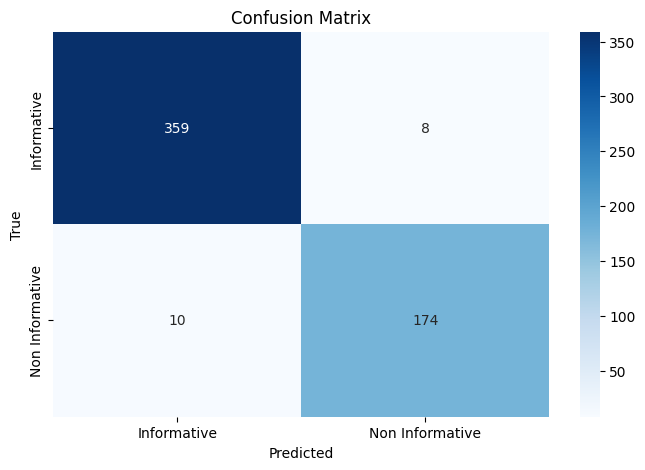

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(all_labels, all_preds):
    labels = ['Informative', 'Non Informative']
    cm = confusion_matrix(all_labels, all_preds, labels=labels)
    plt.figure(figsize=(8, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig('/kaggle/working/ViT_confusion_matrix.png')
    plt.show()

import matplotlib.pyplot as plt
import seaborn as sns
plot_confusion_matrix(all_labels, all_preds)